# LGBM 라벨인코딩 변수선택

In [6]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [7]:
# 필요한 sklearn import 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [9]:
# train data set
loan_train = pd.read_csv('../label_loan_train.csv')

In [10]:
loan_train

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Grade,Sub Grade,Home Ownership,Employment Duration,Verification Status,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,10000,32236,12329.36286,59,11.135007,1,13,0,176346.62670,0,...,2.498291,0.793724,0,0,49,0,31,311301,6619,0
1,3609,11940,12191.99692,59,12.237563,2,17,2,39833.92100,1,...,2.377215,0.974821,0,0,109,0,53,182610,20885,0
2,28276,9311,21603.22455,59,12.545884,5,18,0,91506.69105,1,...,4.316277,1.020075,0,0,66,0,34,89801,26155,0
3,11170,6954,17877.15585,59,16.731201,2,12,0,108286.57590,1,...,0.107020,0.749971,0,0,39,0,40,9189,60214,0
4,16890,13226,13539.92667,59,15.008300,2,18,0,44234.82545,1,...,1294.818751,0.368953,0,0,18,0,430,126029,22579,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62842,11440,17672,22965.76290,59,15.025260,2,5,2,76128.78634,2,...,0.061096,0.325564,0,0,151,0,38,859647,21468,0
62843,8323,11046,15637.46301,59,9.972104,2,7,2,65491.12817,1,...,2.015494,1.403368,0,0,14,0,37,22692,8714,0
62844,15897,32921,12329.45775,59,19.650943,0,27,0,34813.96985,2,...,5.673092,1.607093,0,0,137,0,17,176857,42330,0
62845,16567,4975,21353.68465,59,13.169095,3,22,1,96938.83564,0,...,1.157454,0.207608,0,0,73,0,61,361339,39075,0


In [11]:
# train data set의 컬럼 확인 
loan_train.columns

Index(['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Interest Rate', 'Grade', 'Sub Grade', 'Home Ownership',
       'Employment Duration', 'Verification Status', 'Loan Title',
       'Debit to Income', 'Delinquency - two years', 'Inquires - six months',
       'Open Account', 'Public Record', 'Revolving Balance',
       'Revolving Utilities', 'Total Accounts', 'Initial List Status',
       'Total Received Interest', 'Total Received Late Fee', 'Recoveries',
       'Collection Recovery Fee', 'Collection 12 months Medical',
       'Application Type', 'Last week Pay', 'Accounts Delinquent',
       'Total Collection Amount', 'Total Current Balance',
       'Total Revolving Credit Limit', 'Loan Status'],
      dtype='object')

In [12]:
# 컬럼간의 상관관계 확인
# plt.figure(figsize = (14, 14))
# sns.heatmap(loan_train.corr(), annot = True, annot_kws={"size": 5})
# plt.savefig('corr.png');

**object의 컬럼을 label encoding 할 필요성이 있어 보임  
null 값이 하나도 없음**

In [13]:
X = loan_train.drop("Loan Status", axis = 1)
y = loan_train["Loan Status"]

In [14]:
# pip install imblearn

In [15]:
# 타겟의 비대칭 데이터 문제를 해결하기 위하여 SMOTETomek를 사용

#데이터 클래스 비율이 너무 차이가 나면(highly-imbalanced data) 
#단순히 우세한 클래스를 택하는 모형의 정확도가 높아지므로 모형의 성능판별이 어려워진다. 
#즉, 정확도(accuracy)가 높아도 데이터 갯수가 적은 클래스의 재현율(recall-rate)이 급격히 작아지는 현상이 발생할 수 있다.

from imblearn.combine import SMOTETomek
from collections import Counter
Counter(y)

os=SMOTETomek(sampling_strategy='auto', random_state = 20)
X_train_ns,y_train_ns=os.fit_resample(X,y)
print("The number of classes before fit {}".format(Counter(y)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0: 61222, 1: 1625})
The number of classes after fit Counter({0: 61196, 1: 61196})


In [16]:
# 데이터 셋 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_ns, y_train_ns, test_size = 0.25, random_state = 20, stratify = y_train_ns)
y_train_ns.value_counts(True), y_test.value_counts(True)
len(X_train.columns)

31

# SelectFromModel 사용

In [17]:
from sklearn.feature_selection import SelectFromModel

f_select = SelectFromModel(LGBMClassifier(random_state = 20),  max_features = 31)
f_select.fit(X_train, y_train)
f_scores = pd.DataFrame()

In [18]:
f_scores['attribute'] = X_train.columns
f_scores['support'] = f_select.get_support()
from_model = f_scores[f_scores['support'] == True]["attribute"].values
from_model

array(['Funded Amount', 'Funded Amount Investor', 'Interest Rate',
       'Employment Duration', 'Loan Title', 'Debit to Income',
       'Open Account', 'Revolving Balance', 'Revolving Utilities',
       'Total Accounts', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Last week Pay', 'Total Collection Amount',
       'Total Current Balance', 'Total Revolving Credit Limit'],
      dtype=object)

# SelectKBest 사용

In [19]:
kbest = ['Delinquency - two years', 'Open Account', 'Total Received Interest',
       'Home Ownership', 'Loan Title', 'Revolving Balance',
       'Verification Status', 'Initial List Status', 'Total Collection Amount',
       'Total Received Late Fee', 'Funded Amount Investor',
       'Employment Duration', 'Total Revolving Credit Limit',
       'Inquires - six months', 'Term', 'Recoveries', 'Total Current Balance',
       'Public Record', 'Grade', 'Funded Amount', 'Last week Pay',
       'Debit to Income', 'Interest Rate', 'Collection Recovery Fee',
       'Sub Grade', 'Total Accounts', 'Revolving Utilities']

In [20]:
select = list(set(kbest).union(set(from_model)))
len(select)

27

In [21]:
X = X_train_ns[select]
y = y_train_ns

In [22]:
# 데이터 셋 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 20, stratify = y)
y_train.value_counts(True), y_test.value_counts(True)

(0    0.5
 1    0.5
 Name: Loan Status, dtype: float64,
 0    0.5
 1    0.5
 Name: Loan Status, dtype: float64)

In [23]:
# lightgbm을 구현하여 shap value를 예측할 것
# ligthgbm 구현

# library
import lightgbm as lgb  # 없을 경우 cmd/anaconda prompt에서 install
from math import sqrt
from sklearn.metrics import mean_squared_error

# lightgbm model
lgb_dtrain = lgb.Dataset(data = X_train, label = y_train) # LightGBM 모델에 맞게 변환
lgb_param = {'max_depth': 10,
            'learning_rate': 0.01, # Step Size
            'n_estimators': 1000, # Number of trees
            'objective': 'regression'} # 목적 함수 (L2 Loss)
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
lgb_model_predict = lgb_model.predict(X_test) # test data 예측
print("RMSE: {}".format(sqrt(mean_squared_error(lgb_model_predict, y_test)))) # RMSE

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3920
[LightGBM] [Info] Number of data points in the train set: 91794, number of used features: 27
[LightGBM] [Info] Start training from score 0.500000
RMSE: 0.25977785649246016


In [24]:
# pip install shap

In [25]:
# shap value를 이용하여 각 변수의 영향도 파악

# !pip install shap (에러 발생시, skimage version 확인 (0.14.2 이상 권장))
# import skimage -> skimage.__version__ (skimage version 확인)
# skimage version upgrade -> !pip install --upgrade scikit-image

# shap value 
import shap
explainer = shap.TreeExplainer(lgb_model) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산

In [26]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [27]:
import skimage

In [28]:
# pip install --upgrade scikit-image

In [29]:
import skimage
print(skimage.__version__)

0.20.0


In [30]:
# 무한 로딩되서 실행 불가
# shap.force_plot(explainer.expected_value, shap_values)

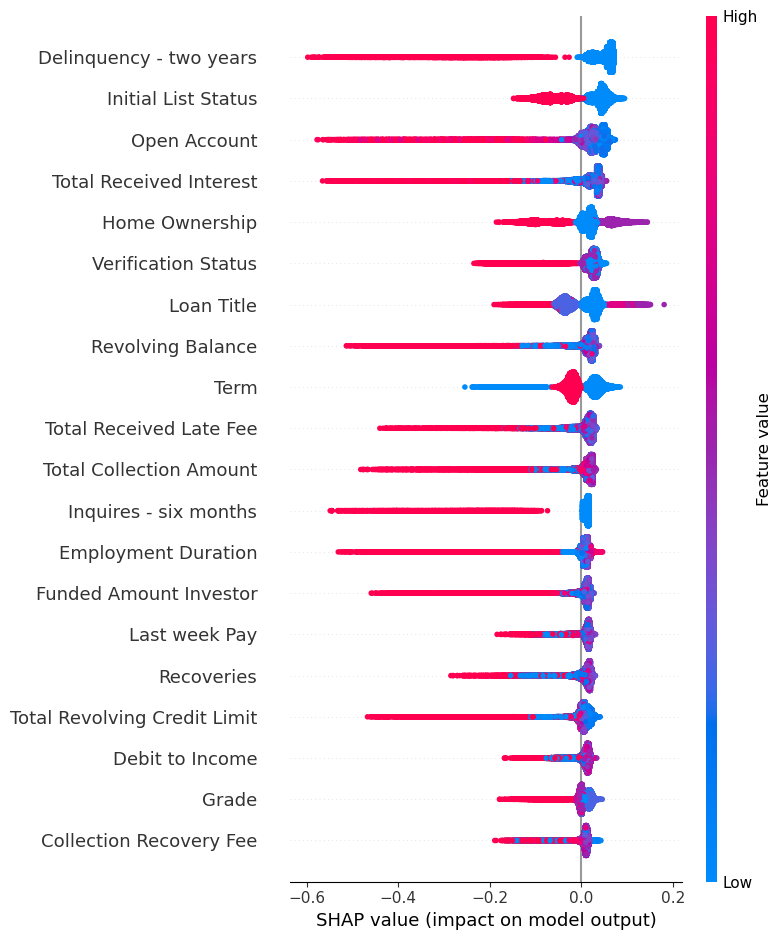

In [31]:
shap.summary_plot(shap_values, X_test)

# LGBM 예측 및 시행

In [32]:
lgbm_clf = LGBMClassifier(n_jobs=-1 , random_state= 20, n_estimators = 1000)

# 학습
lgbm_clf.fit(X_train,y_train)

LGBMClassifier(n_estimators=1000, random_state=20)

In [37]:
from getscore import get_eval_score
get_eval_score(y_train, lgbm_clf.predict(X_train), lgbm_clf.predict_proba(X_train)[:,1])
get_eval_score(y_test, lgbm_clf.predict(X_test),lgbm_clf.predict_proba(X_test)[:,1])

----------------------------------------------------------------------------------------------------
오차행렬:
[[45780   117]
 [    0 45897]]
정확도: 0.9987254 정밀도: 0.9974573 재현율: 1.0000000 F1:0.9987270 AUC: 0.9999987
----------------------------------------------------------------------------------------------------
오차행렬:
[[14546   753]
 [   54 15245]]
정확도: 0.9736257 정밀도: 0.9529316 재현율: 0.9964704 F1:0.9742148 AUC: 0.9974812
